# Сравнение методов выделения и описания ключевых точек



## Подготовка данных

Так как мы хотим понять, какой метод лучше всего выделяет ключевые точки и обеспечивает их повторяемость на изображениях пересеченной местности, то для сравнительного анализа возьмем запись полета беспилотника по редколесью и разбьём её на кадры.

In [1]:
!pip install imageio-ffmpeg
!pip install geopy
!pip install matplotlib
!pip install --no-binary=opencv-contrib-python opencv-contrib-python
!pip install transformers
!pip install torch
!pip install torchvision

In [9]:
import imageio
from pathlib import Path


def split_video(video_path, frame_output):
    output_dir = Path(frame_output)
    output_dir.mkdir(parents=True, exist_ok=True)

    reader = imageio.get_reader(Path(video_path))

    for frame_number, img in enumerate(reader):
        imageio.imwrite(output_dir.joinpath(f"frame_{frame_number}.jpg"), img)


видео, которое использовалось для эксперимента можно получить по ссылке https://drive.google.com/drive/folders/1JktoDBQWU8F6r_DbYf0hvE6-pc2Lyi9T?usp=sharing

In [10]:
split_video(video_path="videos/test-flight.mp4", frame_output="dataset/raw")

 Координаты на снимках с беспилотника меняются каждые три кадра, поэтому по координатам можно высчитать примерное расстояние, которое пролетает за этот момент беспилотник.

In [14]:
from geopy.distance import geodesic

frame1501 = (56.659766, 38.997759)
frame1504 = (56.659758, 38.997765)
frame1507 = (56.659750, 38.997770)
frame1510 = (56.659742, 38.997776)
frame1513 = (56.659734, 38.997782)
frame1531 = (56.659683, 38.997817)

print(geodesic(frame1501, frame1504).meters)
print(geodesic(frame1504, frame1507).meters)
print(geodesic(frame1507, frame1510).meters)
print(geodesic(frame1510, frame1513).meters)
print(geodesic(frame1501, frame1531).meters)

0.9638301627783645
0.9421249214085564
0.963830221013257
0.9638302496013329
9.903169092648962


Благодаря этой информации сформируем два датасета – с малым межкадровым смещением (~ 1 м, каждый третий кадр) и с большим межкадровым смещением (~ 10 м, каждый тридцатый кадр).

In [17]:
import os
import shutil
from pathlib import Path

def get_comparison_datasets(frames_path, small_movement_dataset, big_movement_dataset):
    small_movement_path = Path(small_movement_dataset)
    small_movement_path.mkdir(parents=True, exist_ok=True)
    big_movement_path = Path(big_movement_dataset)
    big_movement_path.mkdir(parents=True, exist_ok=True)

    all_frames = sorted(os.listdir(frames_path), key=lambda name: int(Path(name).stem.split("_")[-1]))
    for i in range(1501, 7501, 3):
        shutil.copyfile(f"{frames_path}/{all_frames[i]}", small_movement_path.joinpath(all_frames[i]))
        if (i - 1) % 30 == 0:
            shutil.copyfile(f"{frames_path}/{all_frames[i]}", big_movement_path.joinpath(all_frames[i]))

    print("Количество изображений с малым межкадровым смещением -", len(os.listdir(small_movement_dataset)))
    print("Количество изображений с большим межкадровым смещением -", len(os.listdir(big_movement_dataset)))

In [18]:
get_comparison_datasets(frames_path="dataset/raw", small_movement_dataset="dataset/small", big_movement_dataset="dataset/big")

Количество изображений с малым межкадровым смещением - 2000
Количество изображений с большим межкадровым смещением - 200


In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [ ]:
def show_images(img1_path, img2_path, title):
    image1 = mpimg.imread(img1_path)
    image2 = mpimg.imread(img2_path)

    fig, axes = plt.subplots(1, 2, figsize=(20, 5))

    fig.suptitle(title, fontsize=18)

    axes[0].imshow(image1)
    axes[0].axis('off')

    axes[1].imshow(image2)
    axes[1].axis('off')

    plt.show()

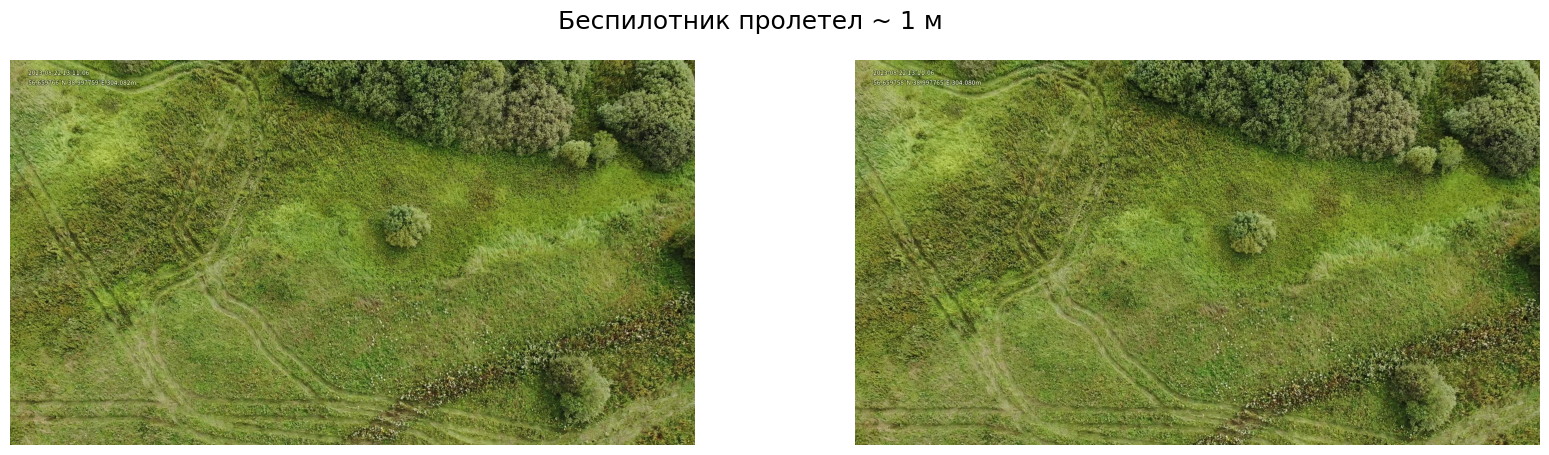

In [59]:
show_images(img1_path="dataset/small/frame_1501.jpg", img2_path="dataset/small/frame_1504.jpg", title="Беспилотник пролетел ~ 1 м")

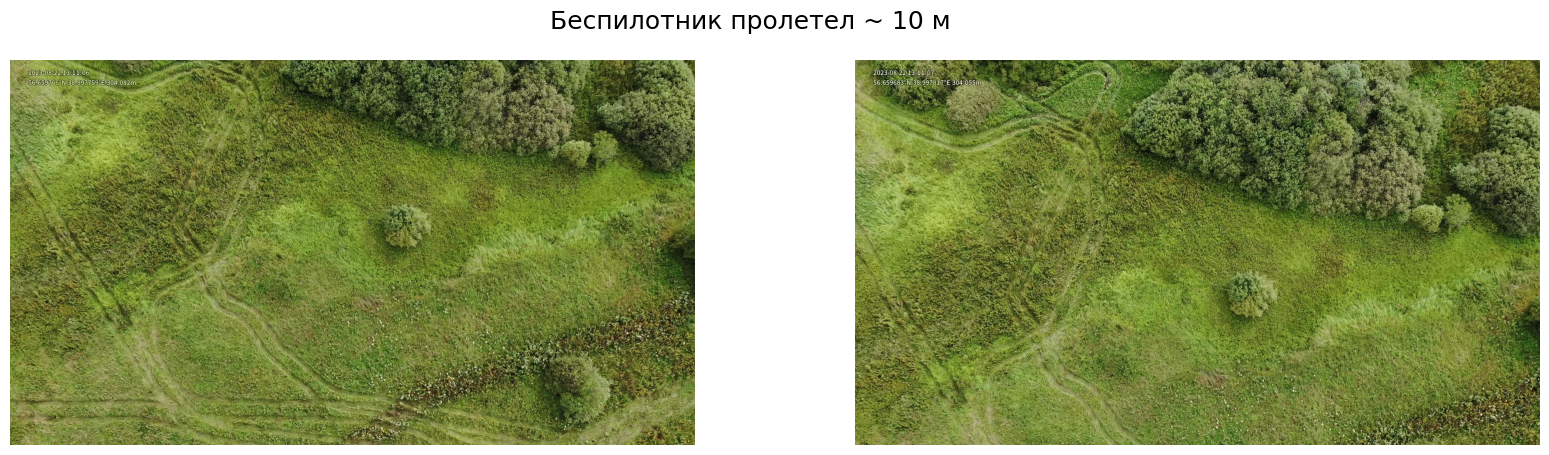

In [60]:
show_images(img1_path="dataset/big/frame_1501.jpg", img2_path="dataset/big/frame_1531.jpg", title="Беспилотник пролетел ~ 10 м")

Всего получилось 2000 изображений с малым межкадровым смещением и 200 изображений с большим межкадровым смещением. Для сравнительного анализа возьмем 200 изображений (199 пар) каждого датасета.

## Методы выделения и описания ключевых точек

Для сравнительного анализа традиционных и нейросетевых подходов выделения ключевых точек на изображениях пересеченной местности возьмем следующие методы:
* **SIFT** – традиционных подход, обеспечивающий высокую точность в определении ключевых точек и их сопоставлении между изображениями, точки остаются инвариантными к изменениям масштаба, поворота и освещения, однако алгоритм требует значительных вычислительных ресурсов и времени, может быть чувствителен к сложным фоновым текстурам (ранее был запатентован, патент вроде истек в 2020);
* **SURF** – традиционных подход, который обеспечивает более высокую скорость детектирования и описания ключевых точек, он также инвариантен к изменениям масштаба, поворота и освещения, хорошо справляется с шумами и искажениями, но при наличии сложных фонов или низких контрастов алгоритм может не всегда точно обнаруживать ключевые точки и в целом немного уступает SIFT в точности, также алгоритм запатентован;
* **ORB** – традиционный подход, один из самых быстрых среди методов детектирования ключевых точек, инвариантный к вращению и масштабированию, использует бинарные дескрипторы и не требует больших вычислительных ресурсов, однако такие дескрипторы могут быть менее информативными и за счёт высокой скорости, алгоритм проигрывает в точности сопоставления более сложным подходам;
* **SuperPoint** – нейросетевой подход, модель способна обрабатывать изображения в реальном времени благодаря своей архитектуре, обеспечивает высокую точность в детектировании ключевых точек и их сопоставлении, можно дообучить под определенную задачу, однако при чрезмерном повороте может не находить сопоставления между ключевыми точками;
* **R2D2** – нейросетевой подход, модель хорошо адаптируется к различным условиям, основное её преимущество заключается в устойчивости к сложным фоновым текстурам, однако она требует значительных вычислительных ресурсов для обучения и работы, что может ограничивать ее использование в реальном времени на менее мощных устройствах.

### Примеры сопоставления ключевых точек каждым из методов

Для пары изображений с большим межкадровым смещением выделим ключевые точки и найдем их дескрипторы каждым из методов. Затем проведем сопоставление выделенных точек, используя сопоставитель FLANN – быструю библиотеку для поиска приближенных ближайших соседей. Ложно-отождествленные сопоставления точек отфильтруем при помощи теста Лёва и выведем получившиеся результаты на изображения.


#### SIFT

In [3]:
import time
def time_of_function(function):
    def wrapped(*args):
        start_time = time.time()
        res = function(*args)
        print(f"Затраченное время - {time.time() - start_time} c.")
        return res

    return wrapped

In [4]:
import cv2

In [ ]:
@time_of_function
def sift_point_matches(image_path1, image_path2):
    img1 = cv2.imread(image_path1)
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.imread(image_path2)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    sift = cv2.SIFT_create(nfeatures=10000)

    keypoints1, descriptors1 = sift.detectAndCompute(img1_gray, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2_gray, None)

    FLAN_INDEX_KDTREE = 0
    index_params = dict(algorithm=FLAN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)
    good_matches = []
    for m1, m2 in matches:
        if m1.distance < 0.5 * m2.distance:
            good_matches.append([m1])

    print("Всего совпадений:", len(matches))
    print("После фильтрации:", len(good_matches))

    image1 = mpimg.imread(image_path1)
    image2 = mpimg.imread(image_path2)

    sift_matches = cv2.drawMatchesKnn(
        image1, keypoints1, image2, keypoints2, good_matches, None, matchColor=(255, 0, 0), flags=2
    )

    plt.figure(figsize=(12, 6))
    plt.imshow(sift_matches)
    plt.axis('off')
    plt.title('SIFT point matches')
    plt.show()


Всего совпадений: 10001
После фильтрации: 212


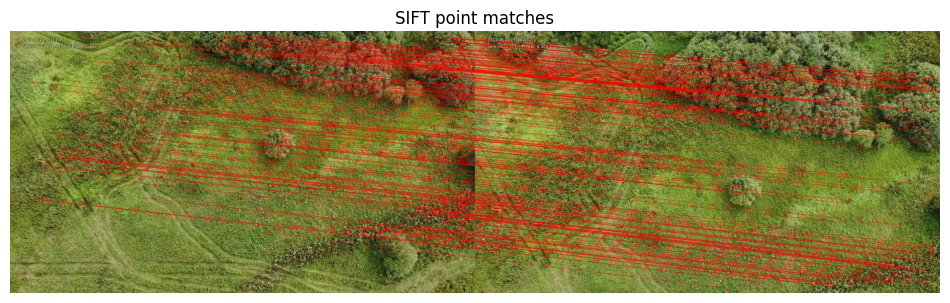

Затраченное время - 4.421056032180786 c.


In [96]:
sift_point_matches("dataset/big/frame_1501.jpg", "dataset/big/frame_1531.jpg")

#### SURF

In [ ]:
@time_of_function
def surf_point_matches(image_path1, image_path2):
    img1 = cv2.imread(image_path1)
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.imread(image_path2)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    surf = cv2.xfeatures2d.SURF_create()

    keypoints1, descriptors1 = surf.detectAndCompute(img1_gray, None)
    keypoints2, descriptors2 = surf.detectAndCompute(img2_gray, None)

    FLAN_INDEX_KDTREE = 0
    index_params = dict(algorithm=FLAN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors1[:10000], descriptors2[:10000], k=2)
    good_matches = []
    for m1, m2 in matches:
        if m1.distance < 0.5 * m2.distance:
            good_matches.append([m1])

    print("Всего совпадений:", len(matches))
    print("После фильтрации:", len(good_matches))

    image1 = mpimg.imread(image_path1)
    image2 = mpimg.imread(image_path2)

    surf_matches = cv2.drawMatchesKnn(
        image1, keypoints1, image2, keypoints2, good_matches, None, matchColor=(255, 0, 0), flags=2
    )

    plt.figure(figsize=(12, 6))
    plt.imshow(surf_matches)
    plt.axis('off')
    plt.title('SURF point matches')
    plt.show()


Всего совпадений: 10000
После фильтрации: 145


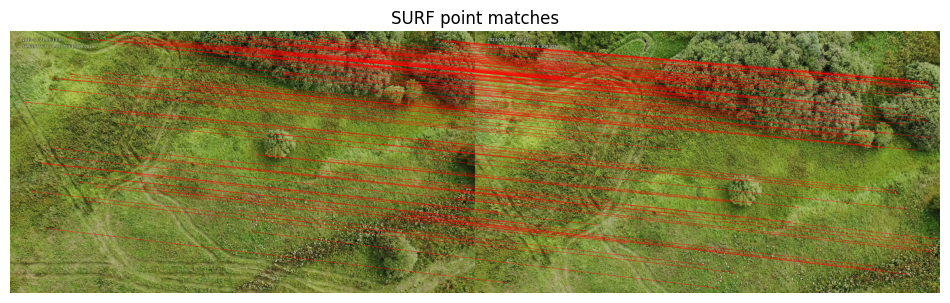

Затраченное время - 3.212873935699463 c.


In [105]:
surf_point_matches("dataset/big/frame_1501.jpg", "dataset/big/frame_1531.jpg")

#### ORB

In [ ]:
@time_of_function
def orb_point_matches(image_path1, image_path2):
    img1 = cv2.imread(image_path1)
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.imread(image_path2)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    orb = cv2.ORB_create(nfeatures=10000)

    keypoints1, descriptors1 = orb.detectAndCompute(img1_gray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(img2_gray, None)

    FLANN_INDEX_LSH = 6
    index_params = dict(
        algorithm=FLANN_INDEX_LSH, table_number=6, key_size=12, multi_probe_level=1
    )
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)
    good_matches = []
    for m1, m2 in matches:
        if m1.distance < 0.5 * m2.distance:
            good_matches.append([m1])

    print("Всего совпадений:", len(matches))
    print("После фильтрации:", len(good_matches))

    image1 = mpimg.imread(image_path1)
    image2 = mpimg.imread(image_path2)

    orb_matches = cv2.drawMatchesKnn(
        image1, keypoints1, image2, keypoints2, good_matches, None, matchColor=(255, 0, 0), flags=2
    )

    plt.figure(figsize=(12, 6))
    plt.imshow(orb_matches)
    plt.axis('off')
    plt.title('ORB point matches')
    plt.show()

Всего совпадений: 10000
После фильтрации: 381


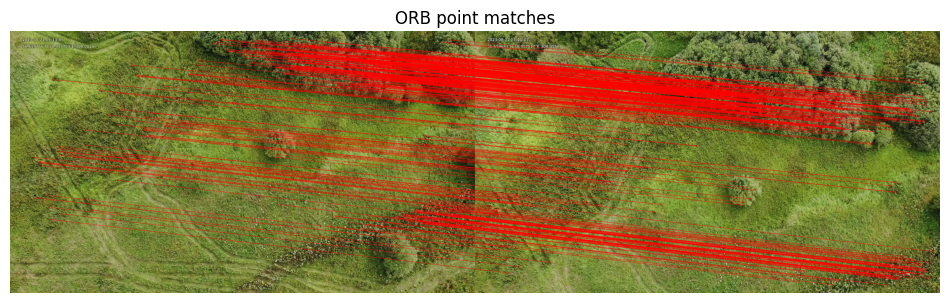

Затраченное время - 0.4787430763244629 c.


In [111]:
orb_point_matches("dataset/big/frame_1501.jpg", "dataset/big/frame_1531.jpg")

#### SuperPoint

In [6]:
from transformers import AutoImageProcessor,SuperPointForKeypointDetection

In [ ]:
@time_of_function
def superpoint_point_matches(image_path1, image_path2):
    img1 = cv2.imread(image_path1)
    img2 = cv2.imread(image_path2)
    images = [img1, img2]

    model = SuperPointForKeypointDetection.from_pretrained("magic-leap-community/superpoint")
    processor = AutoImageProcessor.from_pretrained("magic-leap-community/superpoint")
    inputs = processor(images=images, return_tensors="pt")
    outputs = model(**inputs)
    image_sizes = [(image.shape[0], image.shape[1]) for image in images]
    outputs = processor.post_process_keypoint_detection(outputs, image_sizes)
    keypoints1 = [cv2.KeyPoint(x=float(kp[0]), y=float(kp[1]), size=1) for kp in outputs[0]["keypoints"]]
    descriptors1 = outputs[0]["descriptors"].detach().numpy()
    keypoints2 = [cv2.KeyPoint(x=float(kp[0]), y=float(kp[1]), size=1) for kp in outputs[1]["keypoints"]]
    descriptors2 = outputs[1]["descriptors"].detach().numpy()

    FLAN_INDEX_KDTREE = 0
    index_params = dict(algorithm=FLAN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(
        descriptors1[:10000], descriptors2[:10000], k=2
    )
    good_matches = []
    for m1, m2 in matches:
        if m1.distance < 0.5 * m2.distance:
            good_matches.append([m1])

    print("Всего совпадений:", len(matches))
    print("После фильтрации:", len(good_matches))

    image1 = mpimg.imread(image_path1)
    image2 = mpimg.imread(image_path2)

    sp_matches = cv2.drawMatchesKnn(
        image1, keypoints1, image2, keypoints2, good_matches, None, matchColor=(255, 0, 0), flags=2
    )

    plt.figure(figsize=(12, 6))
    plt.imshow(sp_matches)
    plt.axis('off')
    plt.title('SuperPoint point matches')
    plt.show()

Всего совпадений: 142
После фильтрации: 52


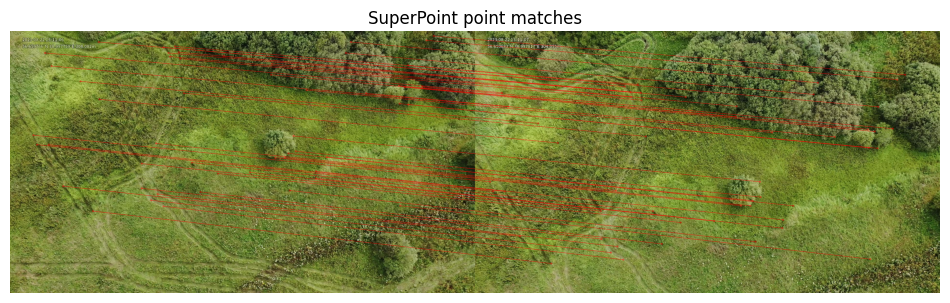

Затраченное время - 3.47243070602417 c.


In [11]:
superpoint_point_matches("dataset/big/frame_1501.jpg", "dataset/big/frame_1531.jpg")

#### R2D2

В эксперименте конкретно рассматривается модель `r2d2_WASF_N16.pt`.

In [14]:
from r2d2.extract import extract_multiscale, load_network, NonMaxSuppression
from r2d2.tools.dataloader import norm_RGB

In [15]:
@time_of_function
def r2d2_point_matches(image_path1, image_path2):
    model = load_network('r2d2/models/r2d2_WASF_N16.pt')
    img1 = cv2.imread(image_path1)
    img2 = cv2.imread(image_path2)
    norm_img1 = norm_RGB(img1)[None]
    norm_img2 = norm_RGB(img2)[None]

    detector = NonMaxSuppression(0.7, 0.7)
    keypoints1, descriptors1, _ = extract_multiscale(model, norm_img1, detector)
    keypoints2, descriptors2, _ = extract_multiscale(model, norm_img2, detector)

    formatted_keypoints1 = [cv2.KeyPoint(x=float(kp[0]), y=float(kp[1]), size=1) for kp in keypoints1]
    formatted_descriptors1 = descriptors1.detach().numpy()
    formatted_keypoints2 = [cv2.KeyPoint(x=float(kp[0]), y=float(kp[1]), size=1) for kp in keypoints2]
    formatted_descriptors2 = descriptors2.detach().numpy()

    FLAN_INDEX_KDTREE = 0
    index_params = dict(algorithm=FLAN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(
        formatted_descriptors1[:10000], formatted_descriptors2[:10000], k=2
    )
    good_matches = []
    for m1, m2 in matches:
        if m1.distance < 0.5 * m2.distance:
            good_matches.append([m1])

    print("Всего совпадений:", len(matches))
    print("После фильтрации:", len(good_matches))

    image1 = mpimg.imread(image_path1)
    image2 = mpimg.imread(image_path2)

    r2d2_matches = cv2.drawMatchesKnn(
        image1, formatted_keypoints1, image2, formatted_keypoints2, good_matches, None, matchColor=(255, 0, 0), flags=2
    )

    plt.figure(figsize=(12, 6))
    plt.imshow(r2d2_matches)
    plt.axis('off')
    plt.title('R2D2 point matches')
    plt.show()

Всего совпадений: 10000
После фильтрации: 408


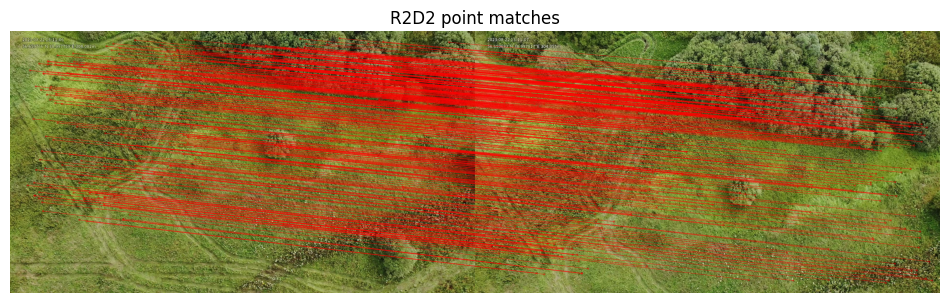

Затраченное время - 19.51354193687439 c.


In [17]:
r2d2_point_matches("dataset/big/frame_1501.jpg", "dataset/big/frame_1531.jpg")

### Определение точности каждого из методов

В качестве метрики точности выделения ключевых точек возьмём оценку средних и медианных расстояний между точками и соответствующими им эпиполярными линиями для пар изображений с известной взаимной ориентацией.

Эксперименты включали два сценария:
* Малое межкадровое смещение: пары изображений со смещением ~1 м.
* Большое межкадровое смещение: пары изображений со смещением ~10 м.

Для каждого из сценариев были проведены следующие действия:
1.	Каждым из исследуемых способов детектирования ключевых точек были выделены точки и вычислены их дескрипторы;
2.	Для каждой пары изображений было проведено сопоставление выделенных точек, используя сопоставитель FLANN – быструю библиотеку для поиска приближенных ближайших соседей;
3.	Ложно-отождествленные сопоставления точек были отфильтрованы при помощи теста Лёва;
4.	Для отфильтрованных точек с помощью фундаментальной матрицы были найдены эпиполярные линии;
5.	Затем были вычислены целевые метрики – расстояния от точки до ее эпиполярной линии;
6.	Для каждого рассмотренного метода детектирования ключевых точек были оценены медианное и среднее расстояния от точек до эпиполярных линий по всем ключевым точкам для всех пар изображений выборки.


#### Способ вычисления фундаментальной матрицы

Фундаментальная матрица удовлетворяет следующему уравнению:

$$ x'^T \cdot F \cdot x' = 0, $$

где x и x' - координаты соответствующих ключевых точек на двух изображениях, F - фундаментальная матрица.


Используем это свойство для ее нахождения - для каждой пары изображений расчитаем фундаментальную матрицу с помощью встроенного в OpenCV метода *findFundamentalMat()* на основе отфильтрованных сопоставлений ключевых точек, найденных методом SIFT.

#### Расстояние до эпиполярной линии

Метрики точности рассчитываются на основе расстояния до эпиполярных линий. Оно определяется следующим образом:

$$ D = d(x, F^T \cdot x') + d(x', F \cdot x) $$

где d(x, l) - расстояние от точки до эпиполярной линии, вычисляемое по формуле:

$$ d(x, l) = \frac{|x \cdot l|}{\sqrt{l_1 + l_2}} $$


In [9]:
import cv2
import numpy as np
from pathlib import Path
import os
from abc import ABC, abstractmethod
from transformers import (
    AutoImageProcessor,
    SuperPointForKeypointDetection,
)
from r2d2.extract import extract_multiscale, load_network, NonMaxSuppression
from r2d2.tools.dataloader import norm_RGB


class Model(ABC):
    @property
    @abstractmethod
    def model(self):
        pass

    def detect_and_compute(self, img_path):
        img = cv2.imread(img_path)
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        keypoints, descriptors = self.model.detectAndCompute(img_gray, None)
        return keypoints, descriptors

    def matches(self, descriptors1, descriptors2):
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(descriptors1, descriptors2, k=2)
        return matches

    def ratio_test(self, matches, kp1, kp2, ratio_index=0.6):
        filtered_keypoints1 = []
        filtered_keypoints2 = []

        for i, (m,n) in enumerate(matches):
            if m.distance < ratio_index * n.distance:
                filtered_keypoints1.append(kp2[m.trainIdx].pt)
                filtered_keypoints2.append(kp1[m.queryIdx].pt)
        return np.int32(filtered_keypoints1), np.int32(filtered_keypoints2)

    def find_epilines(self, kp, F):
        lines = cv2.computeCorrespondEpilines(kp, 2, F)
        return lines.reshape(-1,3)

    def dist_measure(self, kp, epiline):
        kp = np.hstack((kp, [[1]]*len(kp)))
        dist = np.multiply(kp, epiline)
        dist = np.sum(dist, axis=1, keepdims=True)
        dist = dist/np.linalg.norm(epiline[:,:2], axis=1, keepdims=True)
        dist = np.abs(dist)
        return dist


class SIFT(Model):
    @property
    def model(self):
        return cv2.SIFT_create(nfeatures=10000)

    def compute_fundamental_matrix(self, kp1, kp2):
        F, mask = cv2.findFundamentalMat(kp1, kp2,cv2.FM_LMEDS)
        return F, mask


class SURF(Model):
    @property
    def model(self):
        return cv2.xfeatures2d.SURF_create()


class ORB(Model):
    @property
    def model(self):
        return cv2.ORB_create(nfeatures=10000)

    def matches(self, descriptors1, descriptors2):
        FLANN_INDEX_LSH = 6
        index_params = dict(
            algorithm=FLANN_INDEX_LSH, table_number=6, key_size=12, multi_probe_level=1
        )
        search_params = dict(checks=50)
        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(descriptors1, descriptors2, k=2)
        return matches


class SuperPoint(Model):
    @property
    def model(self):
        return SuperPointForKeypointDetection.from_pretrained("magic-leap-community/superpoint")

    def detect_and_compute(self, img_path):
        img = cv2.imread(img_path)
        processor = AutoImageProcessor.from_pretrained("magic-leap-community/superpoint", use_fast=True)
        inputs = processor(img, return_tensors="pt")
        outputs = self.model(**inputs)
        outputs = processor.post_process_keypoint_detection(outputs, [(img.shape[0], img.shape[1])])
        keypoints = outputs[0]["keypoints"]
        descriptors = outputs[0]["descriptors"]
        formatted_keypoints = [cv2.KeyPoint(x=float(kp[0]), y=float(kp[1]), size=1) for kp in keypoints]
        formatted_descriptors = descriptors.detach().numpy()
        return formatted_keypoints, formatted_descriptors


class R2D2(Model):
    @property
    def model(self):
        return load_network('r2d2/models/r2d2_WASF_N16.pt')

    def detect_and_compute(self, img_path):
        detector = NonMaxSuppression(0.7, 0.7)
        img = cv2.imread(img_path)
        img = norm_RGB(img)[None]
        keypoints, descriptors, _ = extract_multiscale(self.model, img, detector)
        formatted_keypoints = [cv2.KeyPoint(x=float(kp[0]), y=float(kp[1]), size=1) for kp in keypoints]
        formatted_descriptors = descriptors.detach().numpy()
        return formatted_keypoints, formatted_descriptors


def run_experiment(dataset_path, num_images=None):
    image_path = Path(dataset_path)
    all_frames = sorted(os.listdir(image_path), key=lambda name: int(Path(name).stem.split("_")[-1]))

    sift = SIFT()
    surf = SURF()
    orb = ORB()
    sp = SuperPoint()
    r2d2 = R2D2()

    sift_sum_dist_all = np.empty(shape=[0, 1])
    surf_sum_dist_all = np.empty(shape=[0, 1])
    orb_sum_dist_all = np.empty(shape=[0, 1])
    sp_sum_dist_all = np.empty(shape=[0, 1])
    r2d2_sum_dist_all = np.empty(shape=[0, 1])

    range_num = num_images - 1 if num_images else len(all_frames) - 1

    for i in range(range_num):
        img1 = image_path / all_frames[i]
        img2 = image_path / all_frames[i + 1]

        # Using SIFT method
        sift_kp1, sift_des1 = sift.detect_and_compute(img1)
        sift_kp2, sift_des2 = sift.detect_and_compute(img2)
        sift_matches = sift.matches(sift_des1, sift_des2)
        sift_good_kp1, sift_good_kp2 = sift.ratio_test(sift_matches, sift_kp1, sift_kp2)
        fund_matrix, mask = sift.compute_fundamental_matrix(sift_good_kp1, sift_good_kp2)

        try:
            sift_epilines1 = sift.find_epilines(sift_good_kp2, fund_matrix)
            sift_epilines2 = sift.find_epilines(sift_good_kp1, fund_matrix)
            sift_dist1 = sift.dist_measure(sift_good_kp1, sift_epilines1)
            sift_dist2 = sift.dist_measure(sift_good_kp2, sift_epilines2)
            sift_sum_dist = sift_dist1 + sift_dist2
            sift_sum_dist_all = np.append(sift_sum_dist_all, sift_sum_dist, axis=0)
        except Exception:
            print("SIFT error:")
            print(f"{len(sift_good_kp1)} good keypoints found in image {all_frames[i]} and {all_frames[i+1]}")

        # Using SURF method
        surf_kp1, surf_des1 = surf.detect_and_compute(img1)
        surf_kp2, surf_des2 = surf.detect_and_compute(img2)
        surf_matches = surf.matches(surf_des1, surf_des2)
        surf_good_kp1, surf_good_kp2 = surf.ratio_test(surf_matches, surf_kp1, surf_kp2)

        try:
          surf_epilines1 = surf.find_epilines(surf_good_kp2, fund_matrix)
          surf_epilines2 = surf.find_epilines(surf_good_kp1, fund_matrix)
          surf_dist1 = surf.dist_measure(surf_good_kp1, surf_epilines1)
          surf_dist2 = surf.dist_measure(surf_good_kp2, surf_epilines2)
          surf_sum_dist = surf_dist1 + surf_dist2
          surf_sum_dist_all = np.append(surf_sum_dist_all, surf_sum_dist, axis=0)
        except Exception:
            print("SURF error:")
            print(f"{len(surf_good_kp1)} good keypoints found in image {all_frames[i]} and {all_frames[i+1]}")

        # Using ORB method
        orb_kp1, orb_des1 = orb.detect_and_compute(img1)
        orb_kp2, orb_des2 = orb.detect_and_compute(img2)
        orb_matches = orb.matches(orb_des1, orb_des2)
        orb_good_kp1, orb_good_kp2 = orb.ratio_test(orb_matches, orb_kp1, orb_kp2)

        try:
          orb_epilines1 = orb.find_epilines(orb_good_kp2, fund_matrix)
          orb_epilines2 = orb.find_epilines(orb_good_kp1, fund_matrix)
          orb_dist1 = orb.dist_measure(orb_good_kp1, orb_epilines1)
          orb_dist2 = orb.dist_measure(orb_good_kp2, orb_epilines2)
          orb_sum_dist = orb_dist1 + orb_dist2
          orb_sum_dist_all = np.append(orb_sum_dist_all, orb_sum_dist, axis=0)
        except Exception:
            print("ORB error:")
            print(f"{len(orb_good_kp1)} good keypoints found in image {all_frames[i]} and {all_frames[i+1]}")

        # Using SuperPoint model
        sp_kp1, sp_des1 = sp.detect_and_compute(img1)
        sp_kp2, sp_des2 = sp.detect_and_compute(img2)
        sp_matches = sp.matches(sp_des1, sp_des2)
        sp_good_kp1, sp_good_kp2 = sp.ratio_test(sp_matches, sp_kp1, sp_kp2)

        try:
            sp_epilines1 = sp.find_epilines(sp_good_kp2, fund_matrix)
            sp_epilines2 = sp.find_epilines(sp_good_kp1, fund_matrix)
            sp_dist1 = sp.dist_measure(sp_good_kp1, sp_epilines1)
            sp_dist2 = sp.dist_measure(sp_good_kp2, sp_epilines2)
            sp_sum_dist = sp_dist1 + sp_dist2
            sp_sum_dist_all = np.append(sp_sum_dist_all, sp_sum_dist, axis=0)
        except Exception:
            print("SuperPoint error:")
            print(f"{len(sp_good_kp1)} good keypoints found in image {all_frames[i]} and {all_frames[i+1]}")

        # Using R2D2 model
        r2d2_kp1, r2d2_des1 = r2d2.detect_and_compute(img1)
        r2d2_kp2, r2d2_des2 = r2d2.detect_and_compute(img2)
        r2d2_matches = r2d2.matches(r2d2_des1, r2d2_des2)
        r2d2_good_kp1, r2d2_good_kp2 = r2d2.ratio_test(r2d2_matches, r2d2_kp1, r2d2_kp2)

        try:
            r2d2_epilines1 = r2d2.find_epilines(r2d2_good_kp2, fund_matrix)
            r2d2_epilines2 = r2d2.find_epilines(r2d2_good_kp1, fund_matrix)
            r2d2_dist1 = r2d2.dist_measure(r2d2_good_kp1, r2d2_epilines1)
            r2d2_dist2 = r2d2.dist_measure(r2d2_good_kp2, r2d2_epilines2)
            r2d2_sum_dist = r2d2_dist1 + r2d2_dist2
            r2d2_sum_dist_all = np.append(r2d2_sum_dist_all, r2d2_sum_dist, axis=0)
        except Exception:
            print("R2D2 error:")
            print(f"{len(r2d2_good_kp1)} good keypoints found in image {all_frames[i]} and {all_frames[i+1]}")

    sift_median_dist = np.median(sift_sum_dist_all)
    sift_average_dist = np.average(sift_sum_dist_all)
    print("SIFT")
    print("average:", sift_average_dist)
    print("median:", sift_median_dist)

    surf_median_dist = np.median(surf_sum_dist_all)
    surf_average_dist = np.average(surf_sum_dist_all)
    print("SURF")
    print("average:", surf_average_dist)
    print("median:", surf_median_dist)

    orb_median_dist = np.median(orb_sum_dist_all)
    orb_average_dist = np.average(orb_sum_dist_all)
    print("ORB")
    print("average:", orb_average_dist)
    print("median:", orb_median_dist)

    sp_median_dist = np.median(sp_sum_dist_all)
    sp_average_dist = np.average(sp_sum_dist_all)
    print("SuperPoint")
    print("average:", sp_average_dist)
    print("median:", sp_median_dist)

    r2d2_median_dist = np.median(r2d2_sum_dist_all)
    r2d2_average_dist = np.average(r2d2_sum_dist_all)
    print("R2D2")
    print("average:", r2d2_average_dist)
    print("median:", r2d2_median_dist)

Посмотрим на результаты работы методов на парах изображений с малым межкадровым смещением:

In [11]:
run_experiment(dataset_path="dataset/small", num_images=200)

SIFT
average: 17.687317678149622
median: 14.86069592378167
SURF
average: 17.40758712259939
median: 14.546765686758171
ORB
average: 16.589818449643758
median: 13.734258741140366
SuperPoint
average: 16.56807684688535
median: 13.919093483860657
R2D2
average: 18.57028866203953
median: 15.970917351561848


ORB показал наименьшее медианное расстояние, по среднему расстоянию на первом месте оказался SuperPoint. Однако и другие методы показывают примерно такие же результаты, без больших выбросов.

Посмотрим на результаты работы методов на парах изображений с большим межкадровым смещением:

In [12]:
run_experiment(dataset_path="dataset/big")

SuperPoint error:
0 good keypoints found in image frame_5551.jpg and frame_5581.jpg
R2D2 error:
0 good keypoints found in image frame_5551.jpg and frame_5581.jpg
SuperPoint error:
0 good keypoints found in image frame_5581.jpg and frame_5611.jpg
R2D2 error:
0 good keypoints found in image frame_5581.jpg and frame_5611.jpg
R2D2 error:
0 good keypoints found in image frame_5611.jpg and frame_5641.jpg
SIFT
average: 112.67550218189244
median: 57.80412450892635
SURF
average: 103.55819203825976
median: 52.804112588261525
ORB
average: 108.32242059486542
median: 60.44863262027502
SuperPoint
average: 97.46559357157021
median: 51.707044169306755
R2D2
average: 106.15640121731046
median: 60.635215811173026


Наилучший результат для всех метрик при эксперименте с большим межкадровым смещением показала модель SuperPoint.
Также при таком эксперименте для пар изображений с большим межкадровым смещением было замечено, что на двух парах кадров в момент разворота беспилотника модели SuperPoint не удалось получить ни одного корректного сопоставления точек, тоже самое не удалось и модели R2D2 на трёх таких парах. При использовании кадров разворота беспилотника с малым смещением, такой проблемы не возникло.